<a href="https://colab.research.google.com/github/Untick/Usedesk/blob/main/Lapkov%20Anatoly/a_lapkov_usedesk_ru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import utils

from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input, concatenate
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop

from IPython.display import display

%matplotlib inline

In [34]:
def get_confirm_token(response):
  for key, value in response.cookies.items():
    if key.startswith('download_warning'):
      return value
  return None

def save_response_content(response, destination):
  CHUNK_SIZE = 32768
  with open(destination, 'wb') as f:
    for chunk in response.iter_content(CHUNK_SIZE):
      if chunk:
        f.write(chunk)

def download_file_from_google_drive(id, destination):
  URL = 'https://docs.google.com/uc?export=download'
  session = requests.Session()
  response = session.get(URL, params = { 'id' : id }, stream = True)
  token = get_confirm_token(response)
  if token:
    params = { 'id' : id, 'confirm' : token }
    response = session.get(URL, params = params, stream = True)
  save_response_content(response, destination)    


In [35]:
FILE_1_ID = '1PwMWQUCETRusiWN9hep2-12GWkdBrpkR'
FILE_1_NAME = 'file_1.xlsx'
FILE_2_ID = '1cCjgzBbSsBnzEfRQ9NgIv_ZVjmRywoqV'
FILE_2_NAME = 'file_2.xlsx'
FILES = {
    FILE_1_ID: FILE_1_NAME,
    FILE_2_ID: FILE_2_NAME
}

In [36]:
for id in FILES:
    if not os.path.exists(FILES[id]):
        download_file_from_google_drive(id, FILES[id])

In [48]:
file_1_data = pd.read_excel(FILE_1_NAME)
file_1_data.drop(columns = [file_1_data.columns[0], file_1_data.columns[1]], axis = 1, inplace = True)
file_2_data, file_2_links = pd.read_excel(FILE_2_NAME, sheet_name = [0, 2]).values()
file_2_data.drop(columns = file_2_data.columns[0], axis = 1, inplace = True)

,comp_id_new,месяц_desc,дата,рейтинг,всего,есть ответ,выполнен,закрыт,nps,email,...,u_incident,u_low,u_medium,u_urgent,u_extreme,licens,бз,бз_ст,без ответа,без ответа %
0,1,1,2023-06-01,2,3709,3442,578,2466,1231,1317,...,0,0,2,0,0,13,1,4,267,0.071987
1,1,2,2023-05-01,2,5573,5301,36,4715,2004,2008,...,0,0,5,0,0,13,1,4,272,0.048807
2,1,3,2023-04-01,2,6138,5983,4,5496,2242,1991,...,0,0,1,0,0,13,1,4,155,0.025253
3,1,4,2023-03-01,2,7834,7664,1,7094,2851,2519,...,0,0,6,0,0,13,1,4,170,0.021700
4,1,5,2023-02-01,2,7344,7252,1,6657,2686,2377,...,0,0,2,0,0,13,1,4,92,0.012527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,1,57,2018-10-01,2,3464,3172,0,2994,12,2863,...,0,0,2,0,0,13,1,4,292,0.084296
57,1,58,2018-09-01,2,2685,2445,0,2353,48,1933,...,0,0,0,0,0,13,1,4,240,0.089385
58,1,59,2018-08-01,2,2596,2335,0,2275,31,1921,...,0,0,1,0,1,13,1,4,261,0.100539
59,1,60,2018-07-01,2,1867,1639,0,1614,67,1042,...,0,0,0,0,0,13,1,4,228,0.122121


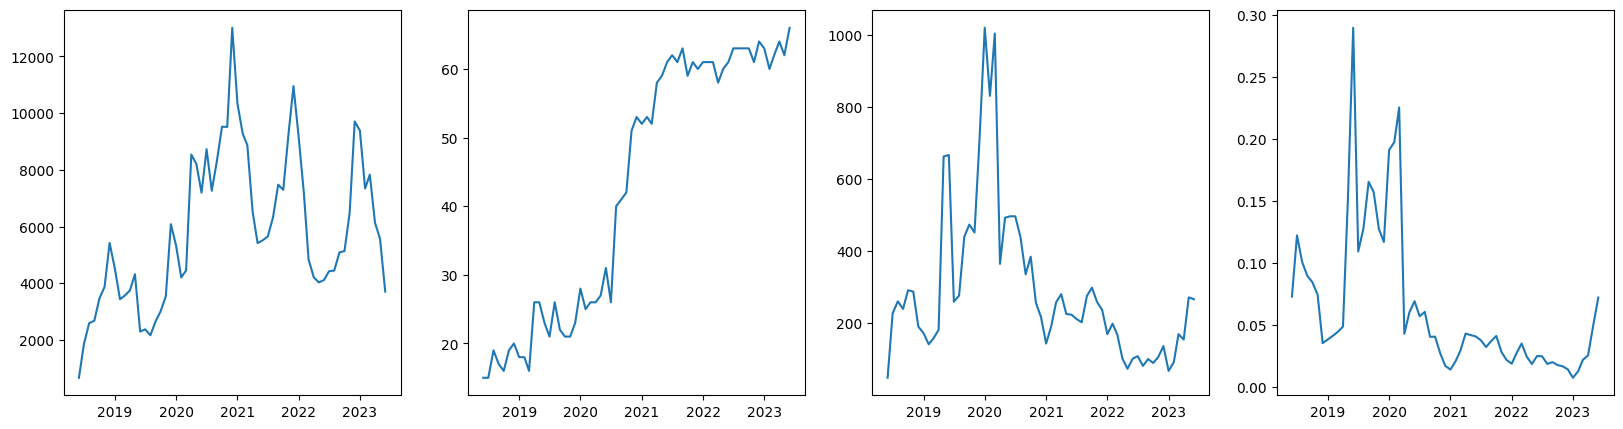

In [49]:
client_1 = file_2_data[file_2_data['comp_id_new'] == 1].copy()
client_1['без ответа'] = client_1['всего'] - client_1['есть ответ']
client_1['без ответа %'] = client_1['без ответа'] / client_1['всего']
display(client_1)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, figsize=(20, 5))
ax1.plot('дата', 'всего', data = client_1)
ax2.plot('дата', 'правила_dist', data = client_1)
ax3.plot('дата', 'без ответа', data = client_1)
ax4.plot('дата', 'без ответа %', data = client_1)
plt.show()


In [39]:
# display(file_1_data)
# display(file_2_data)
# display(file_2_links)

In [40]:
# display(file_1_data.dtypes)
# display(file_2_data.dtypes)
# display(file_2_links.dtypes)

In [100]:
corr_wodate_abs = file_2_data.drop('дата', axis = 1).corr().abs()
corr_high = corr_wodate_abs[(corr_wodate_abs['рейтинг'] < 1.) & (corr_wodate_abs['рейтинг'] >= 0.07)]
# display(corr_wodate_abs.sort_values('рейтинг', ascending = False).head(10))
corr_cols = corr_high.index.to_list()
# display(corr_cols)
# display(len(corr_cols))
corr_data = file_2_data[corr_cols]
display(corr_data.head(20))


,всего,есть ответ,закрыт,nps,email,usedesk_chat,telegram,whatsapp,fb_instagram,question,medium,правила_dist,licens,бз,бз_ст
0,3709,3442,2466,1231,1317,779,737,778,70,3376,2568,66,13,1,4
1,5573,5301,4715,2004,2008,1248,1125,1089,66,5107,3735,62,13,1,4
2,6138,5983,5496,2242,1991,1440,1222,1378,78,5611,4114,64,13,1,4
3,7834,7664,7094,2851,2519,1856,1559,1765,106,7191,5313,62,13,1,4
4,7344,7252,6657,2686,2377,1764,1552,1596,25,6724,4894,60,13,1,4
5,9389,9321,8579,3441,3182,2002,1813,2206,152,8469,6416,63,13,1,4
6,9709,9572,8870,3975,3300,2330,1701,2298,42,8722,6314,64,13,1,4
7,6497,6390,5933,2604,2307,1657,1125,1307,68,5928,4233,61,13,1,4
8,5139,5049,4750,2017,1756,1258,911,1141,50,4712,3408,63,13,1,4
9,5092,4991,4623,2008,1915,1293,744,1045,61,4617,3259,63,13,1,4


In [101]:
CLASSES_CNT = len(file_2_data['рейтинг'].unique())
y_data = utils.to_categorical(file_2_data['рейтинг'].copy(), CLASSES_CNT)
display(CLASSES_CNT)
display(y_data[:20])


4

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [108]:
model = Sequential()
model.add(Input(shape = (corr_data.shape[1])))
model.add(BatchNormalization())
model.add(Dense(1000, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(500, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(100, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(y_data.shape[1], activation = 'softmax'))

In [109]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [110]:
history = model.fit(corr_data, y_data, epochs = 10, validation_split = 0.2, verbose = 1)

Epoch 1/10


2023-07-31 18:48:15.054752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-31 18:48:15.142131: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


295/295 [==============================] - ETA: 0s - loss: 1.3762 - accuracy: 0.3466

2023-07-31 18:48:26.605596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


295/295 [==============================] - 14s 43ms/step - loss: 1.3762 - accuracy: 0.3466 - val_loss: 1.3844 - val_accuracy: 0.3192
Epoch 2/10
295/295 [==============================] - 14s 46ms/step - loss: 1.3564 - accuracy: 0.3467 - val_loss: 1.3992 - val_accuracy: 0.3014
Epoch 3/10
295/295 [==============================] - 14s 47ms/step - loss: 1.3747 - accuracy: 0.3514 - val_loss: 1.4055 - val_accuracy: 0.3824
Epoch 4/10
295/295 [==============================] - 15s 50ms/step - loss: 1.4049 - accuracy: 0.3435 - val_loss: 1.4611 - val_accuracy: 0.3192
Epoch 5/10
295/295 [==============================] - 15s 51ms/step - loss: 1.4559 - accuracy: 0.3421 - val_loss: 1.4743 - val_accuracy: 0.3756
Epoch 6/10
295/295 [==============================] - 15s 51ms/step - loss: 1.5200 - accuracy: 0.3330 - val_loss: 1.4721 - val_accuracy: 0.3480
Epoch 7/10
295/295 [==============================] - 14s 47ms/step - loss: 1.5806 - accuracy: 0.3251 - val_loss: 1.5057 - val_accuracy: 0.3519
Epo

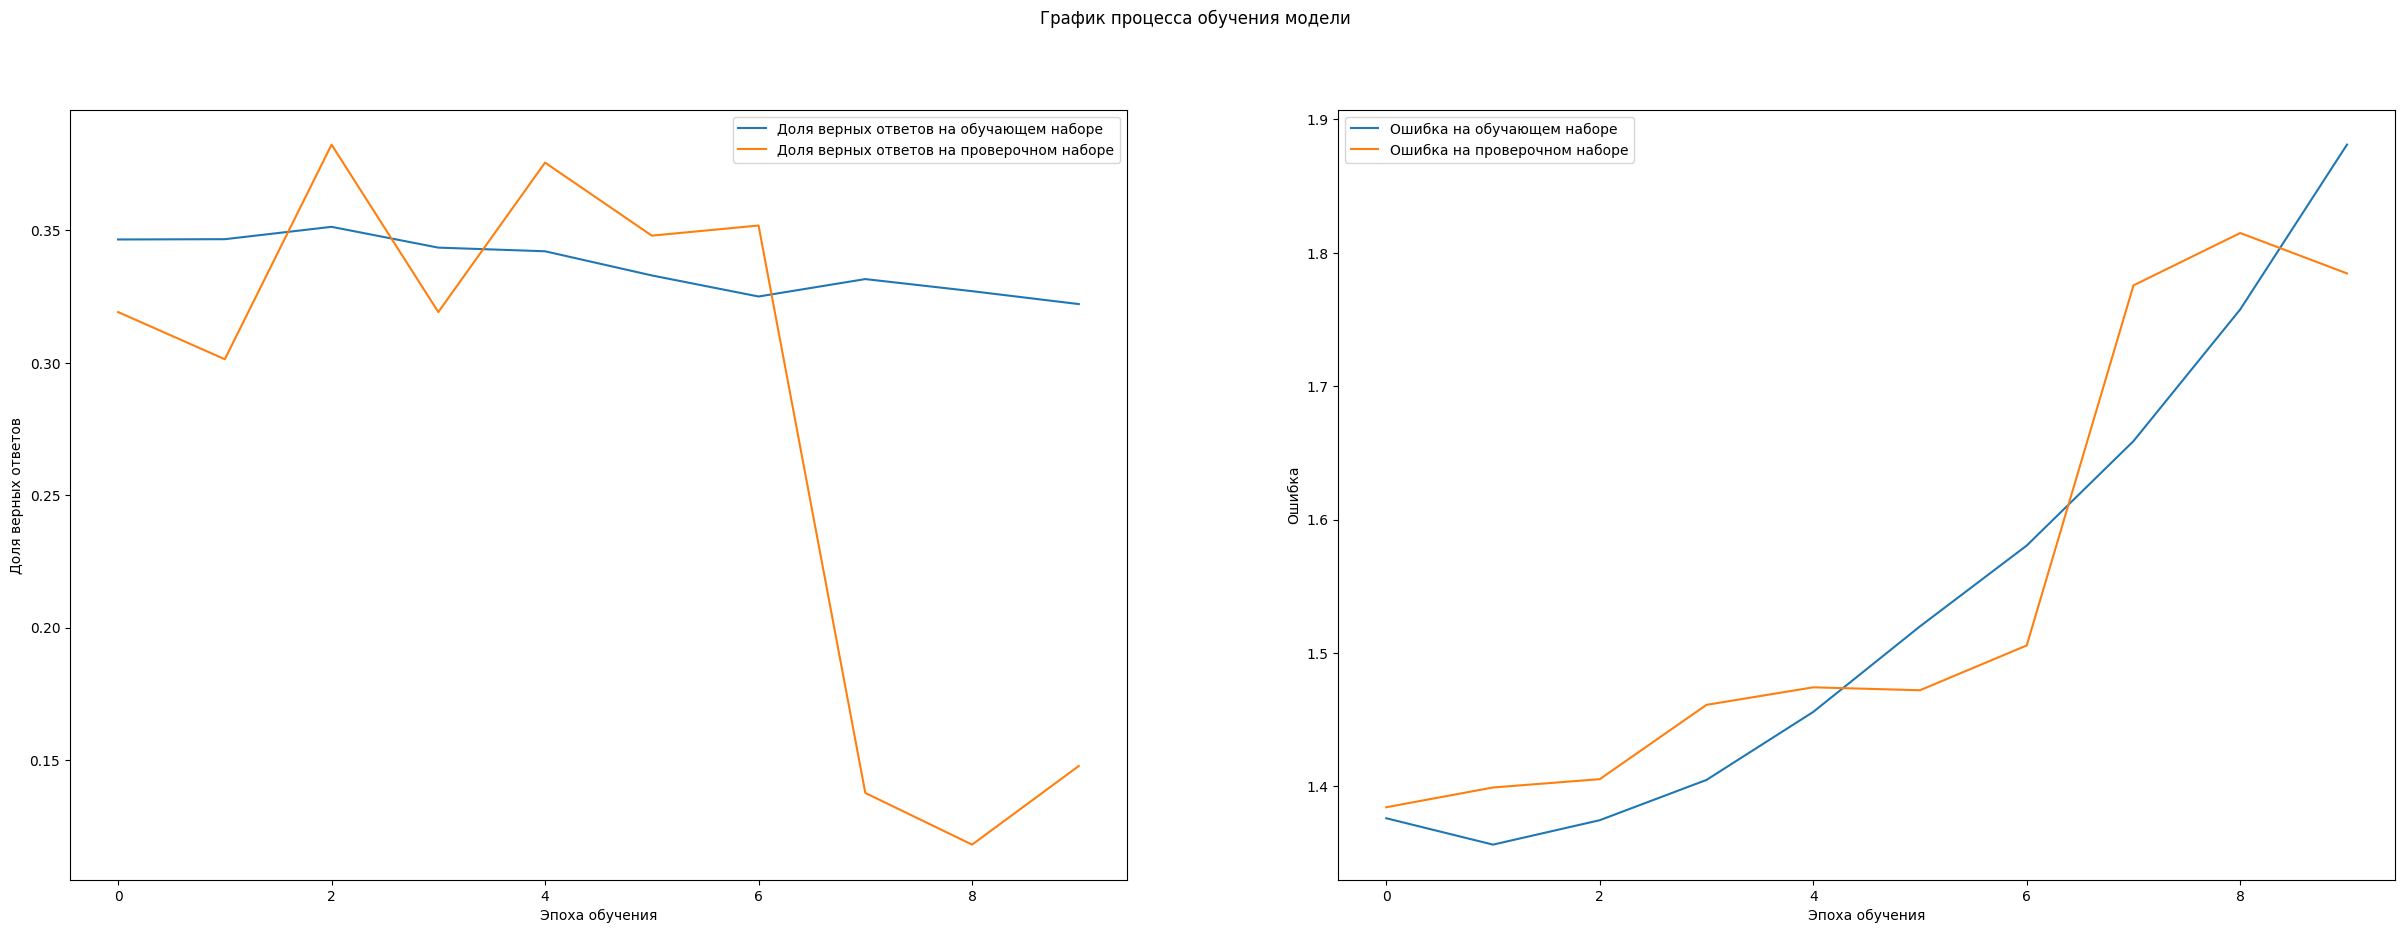

In [111]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (30, 10))
fig.suptitle('График процесса обучения модели')
ax1.plot(history.history['accuracy'], label = 'Доля верных ответов на обучающем наборе')
ax1.plot(history.history['val_accuracy'], label = 'Доля верных ответов на проверочном наборе')
ax1.xaxis.get_major_locator().set_params(integer = True)
ax1.set_xlabel('Эпоха обучения')
ax1.set_ylabel('Доля верных ответов')
ax1.legend()

ax2.plot(history.history['loss'], label = 'Ошибка на обучающем наборе')
ax2.plot(history.history['val_loss'], label = 'Ошибка на проверочном наборе')
ax2.xaxis.get_major_locator().set_params(integer = True)
ax2.set_xlabel('Эпоха обучения')
ax2.set_ylabel('Ошибка')
ax2.legend()
plt.show()